# Public Transport Victoria (PTV) Timetable API v3
This notebook is part of the [PTV_v3 repository](https://github.com/r1cc4rdo/PTV_v3.git) on Github.

## Preliminaries: composing, signing and making a request
To instantiate a ```PTVv3``` object, you will need to obtain [your own id/key pair](https://www.ptv.vic.gov.au/assets/default-site/footer/data-and-reporting/Datasets/PTV-Timetable-API/60096c0692/PTV-Timetable-API-key-and-signature-document.rtf) from PTV.

In [1]:
from ptvv3 import PTVv3

ptv_id = input('PTV id: ')
ptv_key = input('PTV key: ')
ptv = PTVv3(ptv_id, ptv_key, debug=True)

PTV id:  <<<your id>>>
PTV key:  <<<your key>>>


In [3]:
route_types = ptv('/v3/route_types')

print({rt["route_type_name"]: rt["route_type"] for rt in route_types['route_types']})
ptv.debug = False  # if execution reached here, it worked! So disable debug output

{'Train': 0, 'Tram': 1, 'Bus': 2, 'Vline': 3, 'Night Bus': 4}


## Discovering bus stops and routes from GPS coordinates

In [4]:
gps_latitude, gps_longitude, radius = -37.9057, 145.0927, 600  # degrees, degrees, meters
stops = ptv(f'/v3/stops/location/{gps_latitude},{gps_longitude}', route_types=2, max_distance=600)
print(f'Found {len(stops["stops"])} bus stops within {radius} meters from ({gps_latitude}, {gps_longitude})')

Found 10 bus stops within 600 meters from (-37.9057, 145.0927)


## Find closest stops for each bus (*i.e. route*)

In [5]:
def closest_stops_per_route(stops):

    stops_info, routes_info = {}, {}
    for stop in sorted(stops['stops'], key=lambda s: s['stop_distance']):  # should already be ordered by distance. sorted is stable
        stops_info[stop['stop_id']] = tuple(stop[field] for field in 'stop_name stop_latitude stop_longitude stop_distance'.split())
        
        for route in stop['routes']:
            if route['route_id'] not in routes_info:
                routes_info[route['route_id']] = tuple(route[name] for name in 'route_number route_name'.split()) + (stop['stop_id'], )
    
    unique_closest_stops = set(ri[-1] for ri in routes_info.values())
    stops_info = {k: v for k, v in stops_info.items() if k in unique_closest_stops}
    return stops_info, routes_info

stops_info, routes_info = closest_stops_per_route(stops)

In [6]:
from IPython.display import HTML, display

def notebook_html_table(data_dict, headers):
    header = '<th>#</th>' + ''.join(f'<th>{name.replace("_", " ")}</th>' for name in headers.split())
    rows = [(index, dk) + dv for index, (dk, dv) in enumerate(data_dict.items())]
    contents = '</tr><tr>'.join(''.join(list(map(lambda x: f'<td>{x}</td>', row))) for row in rows)
    display(HTML(f'<table><thead><tr>{header}</tr></thead><tr>{contents}</tr></table>'))

In [7]:
notebook_html_table(routes_info, 'Route_ID Bus_number Route_name Stop_ID')
notebook_html_table(stops_info, 'Stop_ID Stop_name Latitude Longitude Distance')

#,Route ID,Bus number,Route name,Stop ID
0,13271,733,Oakleigh - Box Hill via Clayton & Monash University & Mt Waverley,22833
1,12753,900,Stud Park SC (Rowville) - Caulfield via Monash University & Chadstone (SMARTBUS Service),16339
2,13665,704,Oakleigh Station - Westall Station via Clayton,16339
3,14930,742,Ringwood - Chadstone SC via Vermont South & Glen Waverley & Oakleigh,16339
4,13067,630,Elwood - Monash University via Gardenvale & Ormond & Huntingdale,22875
5,8922,862,Dandenong - Chadstone via North Dandenong & Oakleigh,10005
6,8924,802,Dandenong - Chadstone via Mulgrave & Oakleigh,10005
7,8934,804,Dandenong - Chadstone via Wheelers Hill & Oakleigh,10005
8,13820,800,Dandenong - Chadstone via Princes Highway & Oakleigh,10005


#,Stop ID,Stop name,Latitude,Longitude,Distance
0,22833,Willgilson Ct/Golf Links Ave,-37.9052925,145.091248,135.15271
1,16339,Westminster St/Burlington St,-37.9021721,145.09494,439.3295
2,22875,Best St/North Rd,-37.9101067,145.091049,511.2509
3,10005,Oakleigh SC/Hanover St,-37.9007721,145.091919,552.747742


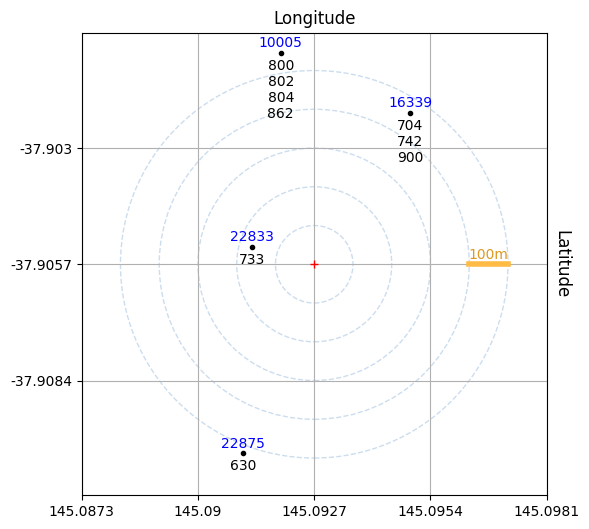

In [8]:
import numpy as np
import matplotlib as mpl
from matplotlib import pyplot as plot

def plot_gps_map(stops_info, routes_info):

    fig = plot.figure(figsize=(6, 6))
    plot.plot(gps_longitude, gps_latitude, 'r+')
    for stop_id, (stop_name, lat, lon, distance) in stops_info.items():  # draw stops
        bus_list = '\n'.join(list(map(str, sorted(ri[0] for ri in routes_info.values() if ri[-1] == stop_id))))
        plot.plot(lon, lat, 'k.')
        plot.annotate(int(stop_id), xy=(lon, lat), xycoords='data', xytext=(0, 12), textcoords='offset points', color='b', va='top', ha='center')
        plot.annotate(bus_list, xy=(lon, lat), xycoords='data', xytext=(0, -4), textcoords='offset points', va='top', ha='center')
    
    # you cannot truly convert from GPS angles to meters unless you're a flat earther, but it's a decent approximation at this scale
    meter = np.linalg.norm([gps_latitude - lat, gps_longitude - lon]) / distance
    lim = 100 * (1 + np.floor(distance / 100))  # plot extent
    
    for index, radius in enumerate(np.arange(100 * meter, lim * meter, 100 * meter)):  # draw circles
        circle = mpl.patches.Circle((gps_longitude, gps_latitude), radius=radius, color='#cde', fill=False, linestyle='--')
        fig.gca().add_patch(circle)
    
    plot.plot([gps_longitude + (lim - 200) * meter, gps_longitude + (lim - 100) * meter], [gps_latitude, gps_latitude], color='#fb4', linewidth=4)  # distance marker
    plot.annotate('100m', xy=(gps_longitude + (lim - 150) * meter, gps_latitude), xycoords='data', xytext=(0, 12), textcoords='offset points', color='#d92', va='top', ha='center')
    
    plot.axis('equal')  # make it pretty: ticks, labels, grid
    xticks = np.linspace(gps_longitude - lim * meter, gps_longitude + lim * meter, 5)
    yticks = np.linspace(gps_latitude - lim * meter, gps_latitude + lim * meter, 5)
    plot.xticks(xticks, np.round(xticks, 4))
    plot.yticks(yticks, np.round(yticks, 4))
    fig.gca().xaxis.set_label_position("top")
    fig.gca().yaxis.set_label_position("right")
    plot.xlabel('Longitude', fontsize='large', va='bottom')
    plot.ylabel('Latitude', rotation=270, fontsize='large', va='bottom')
    plot.grid()
    plot.show()

plot_gps_map(stops_info, routes_info)

## Directions of travel for a route

In [9]:
route_id = next(iter(routes_info.keys()))
directions = ptv(f'/v3/directions/route/{route_id}')

directions_names = {d['direction_id']: d['direction_name'] for d in directions['directions']}
print(directions_names)

{30: 'Box Hill', 182: 'Oakleigh'}


## Real-time bus location

In [10]:
route_id, (_, _, stop_id) = next(iter(routes_info.items()))
direction_id = next(iter(directions_names.keys()))

In [11]:
stops = ptv(f'/v3/stops/route/{route_id}/route_type/2', stop_disruptions='true', include_geopath='true', direction_id=direction_id)
departures = ptv(f'/v3/departures/route_type/2/stop/{stop_id}/route/{route_id}', direction_id=direction_id)
runs = ptv(f'/v3/runs/route/{route_id}/route_type/2', expand='All')

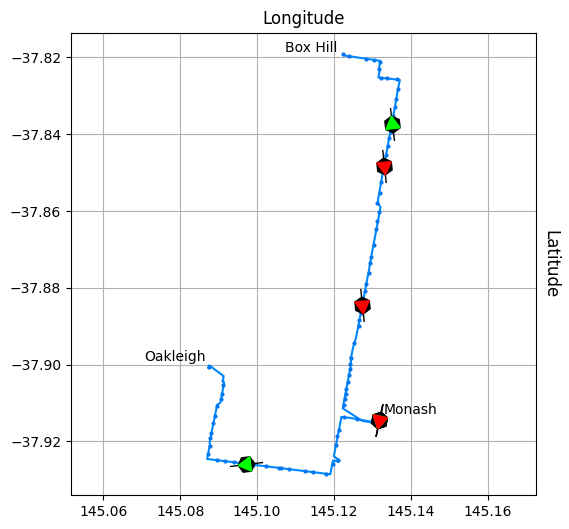

In [12]:
from datetime import datetime

def plot_bus_map(stops, runs, stop_id):

    fig = plot.figure(figsize=(6, 6))
    
    # sorting by stop_sequence does not seem to work, as there are multiple 0 entries. stop_sequence needs a direction_id
    stops_coords = np.array([[stop[key] for key in 'stop_latitude stop_longitude'.split()] for stop in stops['stops'] if stop['stop_sequence'] != 0])
    disruption_coords = np.array([[stop[key] for key in 'stop_latitude stop_longitude'.split()] for stop in stops['stops'] if stop['disruption_ids']])

    paths = stops['geopath'][0]['paths']
    for index, path in enumerate(paths):
        str_coords = path.replace(', ', ',').split()
        coords = np.array([list(map(float, str_coord.split(','))) for str_coord in str_coords])
        plot.plot(coords[:, 1], coords[:, 0], '#08f', zorder=10)

    if len(disruption_coords):
        plot.plot(disruption_coords[:, 1], disruption_coords[:, 0], 'ro', zorder=20)

    for run in runs['runs']:
        if not run['vehicle_position']:
            continue

        utc_string = run['vehicle_position']['datetime_utc']
        utc_format = f'%Y-%m-%dT%H:%M:%S{".%f" if "." in utc_string else ""}Z'
        utc_ts = datetime.strptime(utc_string, utc_format)
        sec_from_ts = (datetime.utcnow() - utc_ts).total_seconds()
                    
        direction = run['vehicle_position']['bearing']
        color = '#0f0' if run['direction_id'] == direction_id else '#f00'
        plot.plot(run['vehicle_position']['longitude'], run['vehicle_position']['latitude'], 'k', marker=(6, 0, direction or 0), markersize=12, zorder=30)
        plot.plot(run['vehicle_position']['longitude'], run['vehicle_position']['latitude'], color, marker=(3 if direction else 6, 0, direction or 0), markersize=12 if direction else 8, zorder=50)
        plot.plot(run['vehicle_position']['longitude'], run['vehicle_position']['latitude'], 'k', marker=(2 if direction else 6, 0, direction or 0), markersize=24 if direction else 0, zorder=40)
            
    plot.plot(stops_coords[:, 1], stops_coords[:, 0], '.', color='#07e', markersize=4, zorder=15)
    plot.annotate('Oakleigh', xy=(145.0873714, -37.9005191), xycoords='data', xytext=(-2, 4), textcoords='offset points', ha='right')
    plot.annotate('Box Hill', xy=(145.1217, -37.82010), xycoords='data', xytext=(-2, 4), textcoords='offset points', ha='right')
    plot.annotate('Monash', xy=(145.1315377, -37.9142599), xycoords='data', xytext=(4, 4), textcoords='offset points')

    fig.gca().xaxis.set_label_position("top")
    fig.gca().yaxis.set_label_position("right")
    plot.xlabel('Longitude', fontsize='large', va='bottom')
    plot.ylabel('Latitude', rotation=270, fontsize='large', va='bottom')
    plot.axis('equal')
    plot.grid()
    plot.show()

plot_bus_map(stops, runs, stop_id)